Load dataframes with acf and calculate tau

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit, OptimizeWarning
from sklearn.metrics import r2_score
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

### Get the data

In [2]:
area = 'pfp' #pfp

In [3]:
results_folder = 'E:\\projects_q_30_10_2024\\isttc\\results\\monkey\\fixation_period_1000ms\\' + area + '\\acf\\'
save_folder = 'E:\\projects_q_30_10_2024\\isttc\\results\\monkey\\fixation_period_1000ms\\' + area + '\\taus\\'

acf_proper_df = pd.read_pickle(results_folder + 'acf_proper_df_constraint_input_50ms_20lags_df.pkl')
acf_pearsonr_df = pd.read_pickle(results_folder + 'acf_pearsonr_df_constraint_input_50ms_20lags_df.pkl')

acf_proper_trial_mean_df = pd.read_pickle(results_folder + 'acf_proper_trial_mean_constraint_input_50ms_20lags_df.pkl')
acf_pearsonr_trial_mean_df = pd.read_pickle(results_folder + 'acf_pearsonr_trial_mean_constraint_input_50ms_20lags_df.pkl')

acf_average_trial_pearsonr_df = pd.read_pickle(results_folder + 'acf_average_trial_pearsonr_constrained_input_50ms_20lags_df.pkl')

### Constraint ACFs

### Calculate tau

In [4]:
def func_single_exp(x, a, b, c):
    """
    Exponential function to fit the data.
    :param x: 1d array, independent variable
    :param a: float, parameter to fit
    :param b: float, parameter to fit
    :param c: float, parameter to fit
    :return: callable
    """
    return a * np.exp(-b * x) + c


def fit_single_exp(ydata_to_fit_, start_idx_=1):
    """
    Fit function func_exp to data using non-linear least square.

    todo check that - important point: Fit is done from the first ACF value (acf[0] is skipped, it is done like this
    in the papers, still not sure)

    :param ydata_to_fit_: 1d array, the dependant data to fit
    :param start_idx_: int, index to start fitting from
    :return: fit_popt, fit_pcov, tau, fit_r_squared
    """
    t = np.linspace(start_idx_, len(ydata_to_fit_)-1, len(ydata_to_fit_)-1).astype(int)

    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        try:
            popt, pcov = curve_fit(func_single_exp, t, ydata_to_fit_[start_idx_:], maxfev=1000000000) # I used 5000, now it is like in Siegle
            fit_popt = popt
            fit_pcov = pcov
            tau = 1 / fit_popt[1]
            # fit r-squared
            y_pred = func_single_exp(t, *popt)
            fit_r_squared = r2_score(ydata_to_fit_[start_idx_:], y_pred)
        except RuntimeError as e:
            print('RuntimeError: {}'. format(e))
            fit_popt, fit_pcov, tau, fit_r_squared = np.nan, np.nan, np.nan, np.nan
        except OptimizeWarning as o:
            print('OptimizeWarning: {}'. format(o))
            fit_popt, fit_pcov, tau, fit_r_squared = np.nan, np.nan, np.nan, np.nan
        except RuntimeWarning as re:
            print('RuntimeWarning: {}'. format(re))
            fit_popt, fit_pcov, tau, fit_r_squared = np.nan, np.nan, np.nan, np.nan
        except ValueError as ve:
            print('ValueError: {}'. format(ve))
            print('Possible reason: acf contains NaNs, low spike count')
            fit_popt, fit_pcov, tau, fit_r_squared = np.nan, np.nan, np.nan, np.nan

    return fit_popt, fit_pcov, tau, fit_r_squared

In [5]:
def calc_tau(acf_df_, acf_cols_):
    acf_2d = acf_df_[acf_cols_].values
    n_units = acf_2d.shape[0]
    print('Calculating taus for {}'.format(acf_2d.shape))
    
    fit_popt_a_l, fit_popt_b_l, fit_popt_c_l = [],[],[]
    fit_tau_l = []
    fit_r_squared_l = []
    
    for i in range(n_units):
        fit_popt, fit_pcov, tau, fit_r_squared = fit_single_exp(acf_2d[i,:], start_idx_=1)
        if  type(fit_popt) == np.ndarray:
            fit_popt_a_l.append(fit_popt[0])
            fit_popt_b_l.append(fit_popt[1])
            fit_popt_c_l.append(fit_popt[2])
        else:
            fit_popt_a_l.append(np.nan)
            fit_popt_b_l.append(np.nan)
            fit_popt_c_l.append(np.nan)
        fit_tau_l.append(tau)
        fit_r_squared_l.append(fit_r_squared)
    
    data_df = np.vstack((fit_popt_a_l, fit_popt_b_l, fit_popt_c_l, fit_tau_l, fit_r_squared_l)).T
    tau_df = pd.DataFrame(data_df, columns=['fit_a', 'fit_b', 'fit_c','tau', 'r_squared'])
    tau_df.insert(0, 'unit_id', acf_df_['unit_id'].values)
    # tau_df.insert(1, 'trial_id', acf_proper_df['trial_id'].values)
    tau_df['tau_ms'] = tau_df['tau'] * 50

    return tau_df

In [6]:
n_lags = 20
acf_cols = ['acf_' + str(i) for i in range(n_lags)]

#### Calc tau (for acf/Pearson) for average over trials and conditions (1 tau per unit)

In [7]:
tau_acf_proper_trial_mean_df = calc_tau(acf_proper_trial_mean_df, acf_cols)

Calculating taus for (318, 20)


In [8]:
tau_acf_proper_trial_mean_df.query('tau_ms > 0 and tau_ms <= 1000').describe()

,unit_id,fit_a,fit_b,fit_c,tau,r_squared,tau_ms
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,272.757576,-3005.570243,3.960800,-0.081516,2.064055,0.339587,103.202746
std,164.795005,39338.695062,5.115404,0.077016,2.511062,0.284775,125.553089
min,0.000000,-218901.663714,0.059258,-0.299850,0.074789,0.000007,3.739467
25%,126.000000,0.072474,0.308081,-0.130678,0.094728,0.087440,4.736403
50%,270.000000,0.770563,0.831821,-0.050248,1.202182,0.261185,60.109120
75%,435.000000,1.443505,10.556534,-0.027374,3.245901,0.600534,162.295029
max,542.000000,217302.186485,13.370890,0.076672,16.875423,0.933961,843.771161


In [9]:
tau_acf_pearsonr_trial_mean_df = calc_tau(acf_pearsonr_trial_mean_df, acf_cols[:-1])

Calculating taus for (318, 19)
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf 

In [10]:
tau_acf_pearsonr_trial_mean_df.query('tau_ms > 0 and tau_ms <= 1000').describe()

,unit_id,fit_a,fit_b,fit_c,tau,r_squared,tau_ms
count,203.000000,203.000000,203.000000,203.000000,203.000000,2.030000e+02,203.000000
mean,275.068966,-1605.148085,4.564797,-0.056996,1.645044,8.276271e-02,82.252184
std,162.603129,11539.389244,5.666041,0.168247,2.304274,1.232052e-01,115.213695
min,0.000000,-68044.750455,0.085275,-0.834936,0.019941,-8.083756e-11,0.997051
25%,141.000000,-0.687936,0.459501,-0.122381,0.099387,9.767623e-03,4.969332
50%,274.000000,0.823348,1.372171,-0.041930,0.728772,2.964336e-02,36.438605
75%,434.500000,1.777321,10.061735,0.042568,2.176362,1.018977e-01,108.818093
max,542.000000,34822.360776,50.147904,0.325266,11.726746,7.171616e-01,586.337290


#### Calc tau (acf/Pearson) per trial (multiple taus per unit)

In [11]:
tau_acf_proper_df = calc_tau(acf_proper_df, acf_cols)

Calculating taus for (21687, 20)
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: ac

In [12]:
tau_acf_proper_df.query('tau_ms > 0 and tau_ms <= 1000').describe()

,unit_id,fit_a,fit_b,fit_c,tau,r_squared,tau_ms
count,15791.000000,15791.000000,15791.000000,15791.000000,15791.000000,1.579100e+04,15791.000000
mean,273.528149,-1831.432920,5.698172,-0.035360,1.260487,2.217768e-01,63.024362
std,161.939174,77029.390646,5.653278,0.041272,2.041206,2.287851e-01,102.060303
min,0.000000,-879238.371362,0.051249,-0.323161,0.019330,-8.671841e-11,0.966487
25%,133.000000,-3.524742,0.676690,-0.045581,0.081482,5.301931e-02,4.074103
50%,271.000000,-0.103600,1.815855,-0.023840,0.550705,1.481016e-01,27.535238
75%,437.000000,1.313014,12.272640,-0.013194,1.477781,3.029291e-01,73.889041
max,542.000000,668418.799986,51.733731,0.087910,19.512612,9.776067e-01,975.630621


In [13]:
tau_acf_pearsonr_df = calc_tau(acf_pearsonr_df, acf_cols[:-1])

Calculating taus for (21687, 19)
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count
ValueError: array must not contain infs or NaNs
Possible reason: ac

In [14]:
tau_acf_pearsonr_df.query('tau_ms > 0 and tau_ms <= 1000').describe()

,unit_id,fit_a,fit_b,fit_c,tau,r_squared,tau_ms
count,2336.000000,2336.000000,2336.000000,2336.000000,2336.000000,2336.000000,2336.000000
mean,262.243151,-6918.984616,5.507908,-0.041184,0.865209,0.039967,43.260463
std,157.717822,21320.078229,4.833384,0.082492,1.362231,0.056324,68.111559
min,0.000000,-169832.760888,0.060226,-0.617381,0.027598,0.000000,1.379892
25%,118.000000,-3488.004019,0.944434,-0.079411,0.093679,0.006266,4.683942
50%,250.000000,-0.482165,2.679850,-0.033614,0.373156,0.021995,18.657793
75%,425.000000,1.095627,10.674769,0.011251,1.058835,0.050830,52.941775
max,542.000000,63352.384958,36.234722,0.226001,16.604175,0.567398,830.208773


#### Calc tau on acf as in Siegle (they use Pearson) - trial average

In [15]:
tau_acf_average_trial_pearsonr_df = calc_tau(acf_average_trial_pearsonr_df, acf_cols)

Calculating taus for (318, 20)


In [16]:
tau_acf_average_trial_pearsonr_df.query('tau_ms > 0 and tau_ms <= 1000').describe()

,unit_id,fit_a,fit_b,fit_c,tau,r_squared,tau_ms
count,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000
mean,267.404858,-6462.054650,3.183381,0.020594,3.179663,0.430824,158.983157
std,159.786386,26069.929042,4.714072,0.077419,3.845659,0.307596,192.282965
min,0.000000,-181845.726656,0.050892,-0.254326,0.074037,0.000288,3.701842
25%,132.000000,-0.300865,0.214368,-0.013956,0.334088,0.133017,16.704420
50%,259.000000,0.213715,0.546319,0.018679,1.830431,0.414795,91.521557
75%,424.000000,0.400545,2.995046,0.053143,4.665452,0.695418,233.272602
max,542.000000,24524.690086,13.506788,0.494198,19.649604,0.980978,982.480186


#### One tau per area 

2 methods of doing that:
* average ACF over units and fit
* fit using all ACFs from all neurons

In [17]:
def calc_tau_area(acf_df_, acf_cols_, start_idx_=1):
    acf_2d = acf_df_[acf_cols_].values
    print(acf_2d.shape)
    
    t = np.linspace(start_idx_, acf_2d.shape[1]-start_idx_, acf_2d.shape[1]-start_idx_).astype(int)
    # print(t)
    
    # make 1d for curve_fit
    acf_1d = np.hstack(acf_2d[:,1:])
    print(acf_1d.shape)
    t_1d = np.tile(t, reps=acf_2d.shape[0])
    print(t_1d.shape)
    
    popt, pcov = curve_fit(func_single_exp, t_1d, acf_1d, maxfev=1000000000) # I used 5000, now it is like in Siegle
    tau = 1 / popt[1]
    
    # fit r-squared
    y_pred = func_single_exp(t_1d, *popt)
    fit_r_squared = r2_score(acf_1d, y_pred)

    return tau, popt, fit_r_squared

In [18]:
def calc_tau_area_mean(acf_df_, acf_cols_, start_idx_=1):
    acf_2d = acf_df_[acf_cols_].values
    acf_mean = np.nanmean(acf_2d, axis=0)
    
    t = np.linspace(start_idx_, len(acf_mean)-1, len(acf_mean)-1).astype(int)
    # print(t)
    
    popt, pcov = curve_fit(func_single_exp, t, acf_mean[1:], maxfev=1000000000) # I used 5000, now it is like in Siegle
    tau = 1 / popt[1]
    
    # fit r-squared
    y_pred = func_single_exp(t, *popt)
    fit_r_squared = r2_score(acf_mean[1:], y_pred)

    return tau, popt, fit_r_squared

In [19]:
# using Siegle style ACFs (Pear)
tau_avg_trial_pearsonr, popt_avg_trial_pearsonr, fit_r_square_avg_trial_pearsonr = calc_tau_area(acf_average_trial_pearsonr_df.dropna(), acf_cols)
print('tau_avg_trial_pearsonr {}, fit_r_square_avg_trial_pearsonr {}'.format(tau_avg_trial_pearsonr*50, fit_r_square_avg_trial_pearsonr))

tau_avg_trial_pearsonr_v2, popt_avg_trial_pearsonr_v2, fit_r_square_avg_trial_pearsonr_v2 = calc_tau_area_mean(acf_average_trial_pearsonr_df.dropna(), 
                                                                                                               acf_cols)
print('tau_avg_trial_pearsonr {}, fit_r_square_avg_trial_pearsonr {}'.format(tau_avg_trial_pearsonr_v2*50, fit_r_square_avg_trial_pearsonr_v2))

(318, 20)
(6042,)
(6042,)
tau_avg_trial_pearsonr 319.05287777997256, fit_r_square_avg_trial_pearsonr 0.13430889683218572
tau_avg_trial_pearsonr 319.0282929105644, fit_r_square_avg_trial_pearsonr 0.9657618077144869


In [20]:
# using unit mean ACFs
tau_acf_proper_tr_mean, popt_acf_proper_tr_mean, fit_r_square_acf_proper_tr_mean = calc_tau_area(acf_proper_trial_mean_df.dropna(), acf_cols)
print('tau_acf_proper_tr_mean {}, fit_r_square_acf_proper_tr_mean {}'.format(tau_acf_proper_tr_mean*50, fit_r_square_acf_proper_tr_mean))

tau_acf_proper_tr_mean_v2, popt_acf_proper_tr_mean_v2, fit_r_square_acf_proper_tr_mean_v2 = calc_tau_area_mean(acf_proper_trial_mean_df.dropna(), acf_cols)
print('tau_acf_proper_tr_mean_v2 {}, fit_r_square_acf_proper_tr_mean_v2 {}'.format(tau_acf_proper_tr_mean_v2*50, fit_r_square_acf_proper_tr_mean_v2))

(318, 20)
(6042,)
(6042,)
tau_acf_proper_tr_mean -3598486.0776029695, fit_r_square_acf_proper_tr_mean 0.052452944394876355
tau_acf_proper_tr_mean_v2 -4557218.830327662, fit_r_square_acf_proper_tr_mean_v2 0.3328267603126458


In [21]:
acf_pearsonr_trial_mean_df.dropna()

,unit_id,acf_0,acf_1,acf_2,acf_3,acf_4,acf_5,acf_6,acf_7,acf_8,acf_9,acf_10,acf_11,acf_12,acf_13,acf_14,acf_15,acf_16,acf_17,acf_18
0,0,1.0,0.249152,-0.379808,-0.204913,-0.277090,-0.495228,-0.058303,0.476366,0.237684,-0.233176,-0.047632,0.484214,0.078426,-0.241350,0.243814,-0.173032,-0.960268,-0.576557,1.0
2,8,1.0,-0.227528,0.069786,0.358274,0.105079,0.314058,-0.545385,0.431423,0.241777,-0.449852,0.301625,-0.306368,0.462184,-0.339904,-0.067356,0.468014,-0.594089,0.977356,-1.0
3,13,1.0,0.508378,0.295544,0.467606,0.365935,0.202802,0.254972,0.129958,0.208730,0.183321,0.177702,0.106158,-0.798970,-0.251288,0.575277,-0.240591,-0.716889,0.970725,1.0
4,14,1.0,-0.128985,0.107925,0.343652,0.020293,-0.035660,0.067879,-0.049511,0.018565,-0.325180,0.264887,0.073299,-0.753521,0.197810,0.497434,-0.633034,0.759848,-0.628619,1.0
5,15,1.0,0.505061,0.691743,0.282756,0.451473,0.292902,0.309718,0.420419,0.247849,0.742911,-0.027837,0.474740,-0.267784,0.180334,-0.367303,-0.416291,-0.375139,-0.033942,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312,532,1.0,-0.103838,0.265746,-0.113027,0.222548,0.296105,0.038808,-0.091026,-0.051514,0.314485,-0.107833,-0.310885,-0.348101,0.451222,0.314347,0.443203,-0.717137,-0.500000,1.0
313,533,1.0,0.072428,-0.355587,-0.193477,-0.107073,0.055116,0.063944,0.111960,0.255050,-0.455971,-0.550571,0.677638,0.619139,0.044803,-0.035209,-0.676864,-0.379450,-0.500000,-1.0
315,536,1.0,0.376852,-0.096646,-0.268440,-0.121272,0.295510,0.390796,0.000403,-0.126120,-0.018978,0.196227,0.365803,0.396405,-0.313027,-0.953153,-0.377914,-0.511254,-0.292306,1.0
316,537,1.0,0.022398,-0.332575,0.178200,-0.189639,-0.246721,0.353869,-0.066858,-0.623821,0.223871,0.465891,-0.275933,0.432842,0.378222,-0.282626,0.361601,0.961442,-0.628619,-1.0


In [22]:
# using unit mean Pearsons
# HERE: dropping ACFs with NaNs!
tau_acf_pearsonr_tr_mean, popt_acf_pearsonr_tr_mean, fit_r_square_acf_pearsonr_tr_mean = calc_tau_area(acf_pearsonr_trial_mean_df.dropna(), acf_cols[:-1])
print('tau_acf_pearsonr_tr_mean {}, fit_r_square_acf_pearsonr_tr_mean {}'.format(tau_acf_pearsonr_tr_mean*50, fit_r_square_acf_pearsonr_tr_mean))

tau_acf_pearsonr_tr_mean_v2, popt_acf_pearsonr_tr_mean_v2, fit_r_square_acf_pearsonr_tr_mean_v2 = calc_tau_area_mean(acf_pearsonr_trial_mean_df.dropna(), acf_cols[:-1])
print('tau_acf_pearsonr_tr_mean_v2 {}, fit_r_square_acf_pearsonr_tr_mean_v2 {}'.format(tau_acf_pearsonr_tr_mean_v2*50, fit_r_square_acf_pearsonr_tr_mean_v2))

(273, 19)
(4914,)
(4914,)
tau_acf_pearsonr_tr_mean -2415400.280810362, fit_r_square_acf_pearsonr_tr_mean 0.00792056797869134
tau_acf_pearsonr_tr_mean_v2 -4355946.5522040725, fit_r_square_acf_pearsonr_tr_mean_v2 0.3928524741788205


In [23]:
df_type_l = ['acf_average_trial_pearsonr_df', 'acf_average_trial_pearsonr_df', 
             'acf_proper_trial_mean_df', 'acf_proper_trial_mean_df', 'acf_pearsonr_trial_mean_df', 'acf_pearsonr_trial_mean_df']
fit_type_l = ['fit_all', 'fit_mean', 'fit_all', 'fit_mean', 'fit_all', 'fit_mean']

tau_ms_l = [tau_avg_trial_pearsonr*50, tau_avg_trial_pearsonr_v2*50, tau_acf_proper_tr_mean*50, tau_acf_proper_tr_mean_v2*50, 
            tau_acf_pearsonr_tr_mean*50, tau_acf_pearsonr_tr_mean_v2*50]

r_squared_l = [fit_r_square_avg_trial_pearsonr, fit_r_square_avg_trial_pearsonr_v2, fit_r_square_acf_proper_tr_mean, fit_r_square_acf_proper_tr_mean_v2, 
            fit_r_square_acf_pearsonr_tr_mean, fit_r_square_acf_pearsonr_tr_mean_v2]

popt_a_l = [popt_avg_trial_pearsonr[0], popt_avg_trial_pearsonr_v2[0], 
            popt_acf_proper_tr_mean[0], popt_acf_proper_tr_mean_v2[0], 
            popt_acf_pearsonr_tr_mean[0], popt_acf_pearsonr_tr_mean_v2[0]]

popt_b_l = [popt_avg_trial_pearsonr[1], popt_avg_trial_pearsonr_v2[1], 
            popt_acf_proper_tr_mean[1], popt_acf_proper_tr_mean_v2[1], 
            popt_acf_pearsonr_tr_mean[1], popt_acf_pearsonr_tr_mean_v2[1]]

popt_c_l = [popt_avg_trial_pearsonr[2], popt_avg_trial_pearsonr_v2[2], 
            popt_acf_proper_tr_mean[2], popt_acf_proper_tr_mean_v2[2], 
            popt_acf_pearsonr_tr_mean[2], popt_acf_pearsonr_tr_mean_v2[2]]

tau_area_df = pd.DataFrame(np.vstack((df_type_l, fit_type_l, tau_ms_l, 
                                      r_squared_l, popt_a_l, popt_b_l, popt_c_l)).T, 
                           columns=['df_type', 'fit_type', 'tau_ms', 'r_squared','popt_a', 'popt_b', 'popt_c'])
tau_area_df

,df_type,fit_type,tau_ms,r_squared,popt_a,popt_b,popt_c
0,acf_average_trial_pearsonr_df,fit_all,319.05287777997256,0.13430889683218572,0.15966561845670887,0.1567138348599424,0.012206524403822677
1,acf_average_trial_pearsonr_df,fit_mean,319.0282929105644,0.9657618077144869,0.1596661028413434,0.15672591149781465,0.012209709886720134
2,acf_proper_trial_mean_df,fit_all,-3598486.0776029695,0.052452944394876355,-537.5011239705569,-1.3894732096144747e-05,537.5495069793149
3,acf_proper_trial_mean_df,fit_mean,-4557218.830327662,0.3328267603126458,-680.7404808838093,-1.0971603923703842e-05,680.7888585850492
4,acf_pearsonr_trial_mean_df,fit_all,-2415400.280810362,0.00792056797869134,-377.97766054000385,-2.070050268571845e-05,378.0656212133499
5,acf_pearsonr_trial_mean_df,fit_mean,-4355946.5522040725,0.3928524741788205,-681.7816882175028,-1.1478561410424198e-05,681.8696533003898


In [30]:
def plot_acf_area_fit(acf_df_, acf_cols_, tau_ms_, popt_, tau_ms_v2_, popt_v2_, start_idx_=1, save_fig=False, file_name=None):
    fig, axes = plt.subplots(1,2, figsize=(12,4))

    n_lags = 20
    t = np.linspace(start_idx_, n_lags-1, n_lags-1).astype(int)
    t_labels = np.linspace(50, 950, n_lags-1).astype(int)
    
    # plot 2 fits
    acf_2d = acf_df_[acf_cols_].values
    for i in range(acf_2d.shape[0]):
        axes[0].scatter(t, acf_2d[i,1:], s=1, color='steelblue')
    axes[0].plot(t, func_single_exp(t, popt_[0], popt_[1], popt_[2]), 'r-', label="Fitted Curve")
    axes[0].set_title('tau ' + str(np.round(tau_ms_ * 50,2)) + ', ' + str(acf_2d.shape[0]) + ' units')
    
    acf_2d_mean = np.nanmean(acf_2d, axis=0)
    axes[1].scatter(t, acf_2d_mean[1:], s=3, color='steelblue')
    axes[1].plot(t, func_single_exp(t, popt_v2_[0], popt_v2_[1], popt_v2_[2]), 'r-', label="Fitted Curve")
    axes[1].errorbar(t, acf_2d_mean[1:], stats.sem(acf_2d, axis=0)[1:], linestyle='None', marker='.')
    axes[1].set_title('tau ' + str(np.round(tau_ms_v2_ * 50,2)) + ', ' + str(acf_2d.shape[0]) + ' units')
    
    #axes[1].set_ylim([0, 0.25])
    
    for ax in axes.flat:
        ax.set_xticks(t)
        ax.set_xticklabels(t_labels, rotation=90)
        ax.set_xlabel('Time lag (ms)')
        ax.set_ylabel('Autocorrelation (a.u.)')  
    
    sns.despine()
    
    if save_fig:
        fig.savefig(file_name, bbox_inches='tight')

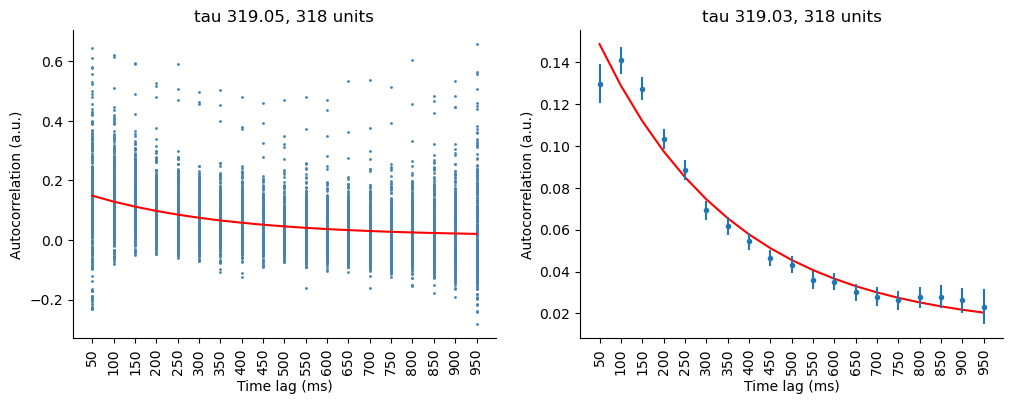

In [25]:
plot_acf_area_fit(acf_average_trial_pearsonr_df, acf_cols, 
                  tau_avg_trial_pearsonr, popt_avg_trial_pearsonr, 
                  tau_avg_trial_pearsonr_v2, popt_avg_trial_pearsonr_v2, 
                  1, True, save_folder + 'tau_avg_trial_pearsonr_50ms_20lags_area.png')

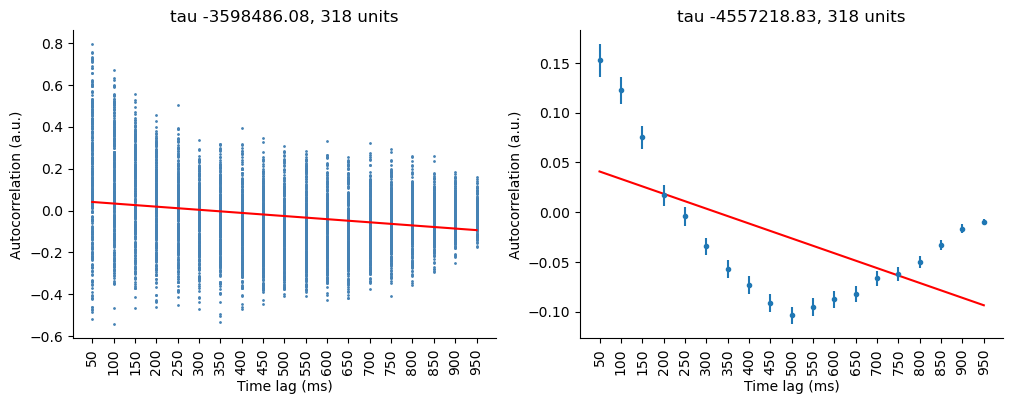

In [26]:
plot_acf_area_fit(acf_proper_trial_mean_df, acf_cols, 
                  tau_acf_proper_tr_mean, popt_acf_proper_tr_mean, 
                  tau_acf_proper_tr_mean_v2, popt_acf_proper_tr_mean_v2, 
                  1, True, save_folder + 'tau_acf_proper_tr_mean_50ms_20lags_area.png')

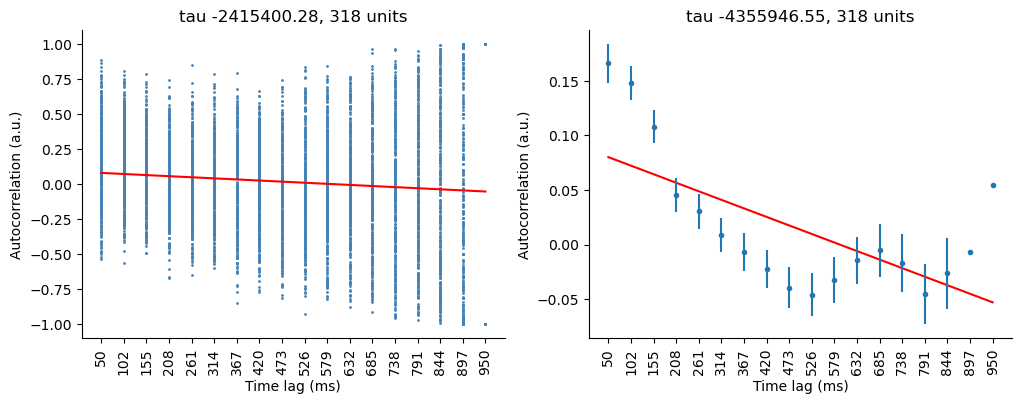

In [29]:
plot_acf_area_fit(acf_pearsonr_trial_mean_df, acf_cols[:-1], 
                  tau_acf_pearsonr_tr_mean, popt_acf_pearsonr_tr_mean, 
                  tau_acf_pearsonr_tr_mean_v2, popt_acf_pearsonr_tr_mean_v2, 
                  1, True, save_folder + 'tau_acf_pearsonr_tr_mean_50ms_20lags_area.png')

### Save all frames

In [31]:
tau_acf_proper_df.to_pickle(save_folder + 'tau_acf_proper_df_constraint_input_50ms_20lags_df.pkl')
tau_acf_pearsonr_df.to_pickle(save_folder + 'tau_acf_pearsonr_df_constraint_input_50ms_20lags_df.pkl')

tau_acf_proper_trial_mean_df.to_pickle(save_folder + 'tau_acf_proper_trial_mean_constraint_input_50ms_20lags_df.pkl')
tau_acf_pearsonr_trial_mean_df.to_pickle(save_folder + 'tau_acf_pearsonr_trial_mean_constraint_input_50ms_20lags_df.pkl')

tau_acf_average_trial_pearsonr_df.to_pickle(save_folder + 'tau_acf_average_trial_pearsonr_df_constrained_input_50ms_20lags_df.pkl')

tau_area_df.to_pickle(save_folder + 'tau_area_df_constrained_input_50ms_20lags_df.pkl')